# Como implementar explicitamente um perceptron multicamadas para aprender uma função de R² em R³ em Python?

Implemente explicitamente um perceptron multicamada no Python e aplique para aprender a seguinte função: f (x, y) = [y ∗ exp(sin(x)), sin(x) ∗ cos(y) , sin(x) + cos(y) ]. Use minibatch gradient descent e gere x e y aleatoriamente no intervalo [0, 2π].



In [142]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import seed


from matplotlib import cm

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


## Geração de dados 

O método *gen_data* recebe como parâmetro de entrada o número de pontos que devem ser gerados para a simulação da rede neural. É gerado um DataFrame no qual cada coluna corresponde, respectivamente aos valores de: $x, y, y*exp(sin(x)), *sin(x) * cos(y)$ e $sen(x) + cos(y)$. Cada uma dessas colunas foi rotulada, respectivamente, de ** X, Y, Z1, Z2 e Z3 **.

In [200]:
seed(128)

def gen_data(sampleSize):
    # Criacao dos dados
    data = np.zeros((sampleSize, 5))
    
    for i in range(sampleSize):
        x = np.random.uniform(0, 2*np.pi)
        y = np.random.uniform(0, 2*np.pi)
        
        data[i] = [x, y, y * np.exp(np.sin(x)), np.sin(x) * np.cos(y), np.sin(x) + np.cos(y)]
      
    return data

samples = 1500
dataset = gen_data(samples)
data = pd.DataFrame(dataset)
data.columns = ['X','Y','Z1','Z2','Z3']
data.head()



,X,Y,Z1,Z2,Z3
0,2.373209,4.532181,9.080939,-0.124563,0.515740
1,1.273711,1.225840,3.189359,0.323342,1.294350
2,5.459229,5.237412,2.514285,-0.367824,-0.232606
3,1.629543,3.185320,8.643673,-0.997321,-0.000769
4,5.474721,3.438946,1.668520,0.691489,-1.679343


## Verificando os dados

Abaixo são desenhados os gráficos das funções que se quer aproximar.

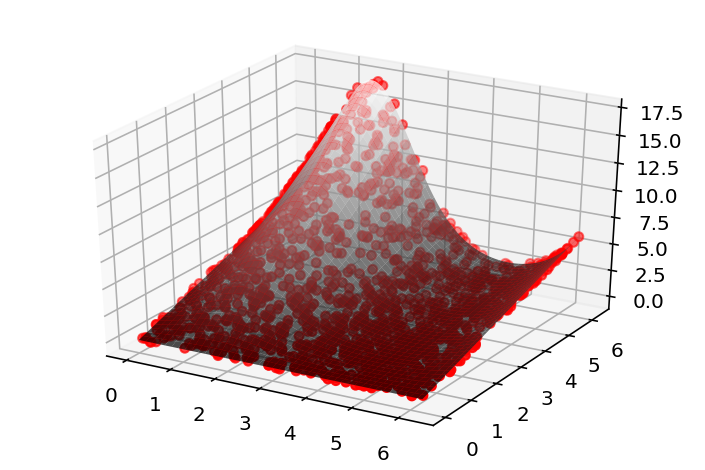

In [201]:
x = np.arange(0, 2 * math.pi, 0.05)
y = np.arange(0, 2 * math.pi, 0.05)
X,Y = np.meshgrid(x,y)
Z = Y * np.exp(np.sin(X))
fig1 = plt.figure()
ax1 = fig1.gca( projection='3d')
ax1.plot_surface(X, Y, Z, cmap=cm.gray, alpha=0.7)
ax1.scatter(data['X'][:] , data['Y'][:],
            data['Z1'][:], c='r')


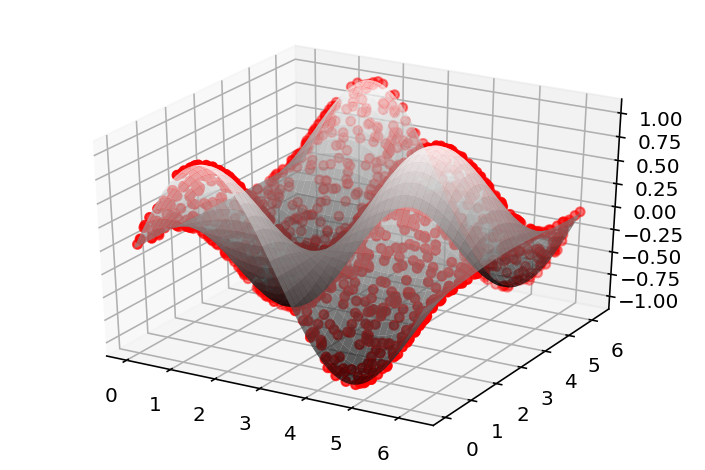

In [202]:
x = np.arange(0, 2 * math.pi, 0.05)
y = np.arange(0, 2 * math.pi, 0.05)
X,Y = np.meshgrid(x,y)
Z = np.sin(X) * np.cos(Y)
fig2 = plt.figure()
ax2 = fig2.gca( projection='3d')
ax2.plot_surface(X, Y, Z, cmap=cm.gray, alpha=0.7)
ax2.scatter(data['X'][:] , data['Y'][:],
            data['Z2'][:], c='r')

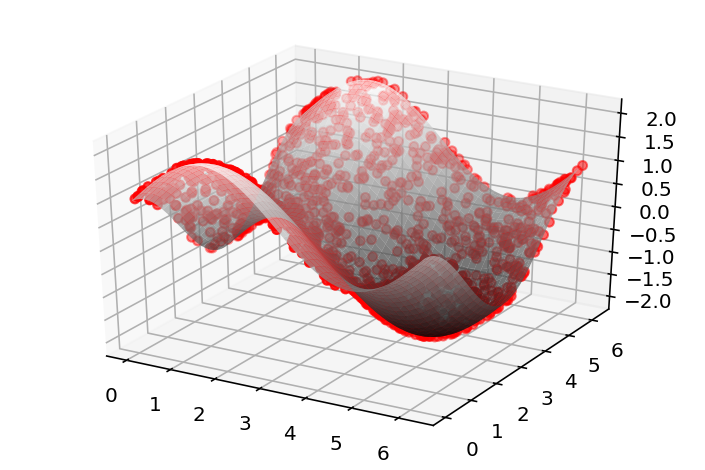

In [203]:
x = np.arange(0, 2 * math.pi, 0.05)
y = np.arange(0, 2 * math.pi, 0.05)
X,Y = np.meshgrid(x,y)
Z = np.sin(X) + np.cos(Y)
fig3 = plt.figure()
ax3 = fig3.gca( projection='3d')
ax3.plot_surface(X, Y, Z, cmap=cm.gray, alpha=0.7)
ax3.scatter(data['X'][:] , data['Y'][:],
            data['Z3'][:], c='r')

### Normaliza os valores dos dados
Para realizar o treinamento da rede neural de modo mais fácil, os valores de cada uma das variáveis deverá ser normalizado. Ou seja, os valores normalizados serão tais que a média deverá ser zero e o desvio padrão 1.


In [221]:
# Store scalings in a dictionary so we can convert back later
scaled_features = {}

for each in data:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std


### Separando a amostra nos conjuntos de treinamento, teste e validação.

Será separado 10% do conjunto de dados para teste.

In [222]:
# 10% dos dados
test_data = data[-int(data.shape[0]*.10):]

# Now remove the test data from the data set 
data = data[:-int(data.shape[0]*.10)]

# Separate the data into features and targets
target_fields = ['Z1', 'Z2', 'Z3']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]



Os dados serão novamente divididos (25% dos dados), porém agora em conjuntos de treinamento e validação. 

In [224]:
##### Separa 25% dos dados restantes para validação
train_features, train_targets = features[:-int(data.shape[0]*.25)], targets[:-int(data.shape[0]*.25)]
val_features, val_targets = features[-int(data.shape[0]*.25):], targets[-int(data.shape[0]*.25):]

## Construção da Rede Neural



In [225]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # configura o número de nós nas camadas de entrada, escondida e saída.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # inicializa os pesos
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        # função de ativação sigmoid
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
                   
    
    def train(self, inputs_list, targets_list):
        #  2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Transmite o sinal para frente ####
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs) # sinal para a camada escondida
        hidden_outputs = self.activation_function(hidden_inputs) # sinal saindo da camada escondida
        
        
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        #### Transmite o sinal para trás ####
       
        # Erro da saída
        output_errors = targets - final_outputs 
        
        # Erro retropropagado.
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors  ) # error propagado para a camada escondida
        hidden_grad =  hidden_outputs * (1-hidden_outputs)# gradientes da camada escondida
        
        # Atualiza os pesos com o gradiente descendente
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T) 
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors*hidden_grad, inputs.T) 
 
        
    def run(self, inputs_list):
        # Executa a transmissão do sinal para frente através da rede
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implementa a transmissão para frente ####
        # Camada escondida.
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # sinal para dentro da camada escondida
        hidden_outputs = self.activation_function(hidden_inputs) # sinal sai da camada escondida
        
        # Camada de saída
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs ) # sinal para dentro da camada de saída
        final_outputs = final_inputs # sinal saindo da camada final 
        
        return final_outputs

In [226]:
# cálculo do erro quadrático médio
def MSE(y, Y):
    return np.mean((y-Y)**2)


## Treinando a rede neural



In [390]:
import sys
from scipy.stats import gmean

### Parâmetros gerais da rede neural ###
epochs = 10000 # número de épocas de treinamento
learning_rate = 0.0001 # taxa de treinamento
hidden_nodes = 4 # número de neurônios na camada escondida
output_nodes = 3 # número de neurônios na camada de saída (3 saídas, 3 neurônios)

N_i = train_features.shape[1] # número de neurônios na camada de entrada
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate) # constrói a rede neural

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Executa um  mini-batch aleatório de 80 registros a partir do conjunto de treinamento
    batch = np.random.choice(train_features.index, size=100)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['Z1']):
        network.train(record, target)
    
    batch = np.random.choice(train_features.index, size=80)
    
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['Z2']):
        network.train(record, target)
    
    batch = np.random.choice(train_features.index, size=80)
    
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['Z3']):
        network.train(record, target)    
    
    # imprime o progresso do treinamento
    # a perda no treinamento é a média geométrica das perdas
    train_loss = gmean( (MSE(network.run(train_features), train_targets['Z1'].values),
    MSE(network.run(train_features), train_targets['Z2'].values),
    MSE(network.run(train_features), train_targets['Z3'].values)))
    # a perda na validação é a média geométrica das perdas
    val_loss = gmean( (MSE(network.run(val_features), val_targets['Z1'].values),
                      MSE(network.run(val_features), val_targets['Z2'].values),
                      MSE(network.run(val_features), val_targets['Z3'].values)) )
    
    sys.stdout.write("\rProgresso: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Custo do treinamento: " + str(train_loss)[:5] \
                     + " ... Custo da validação: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progresso: 99.9% ... Custo do treinamento: 0.620 ... Custo da validação: 0.660

(0.59762922802842611, 1.0)

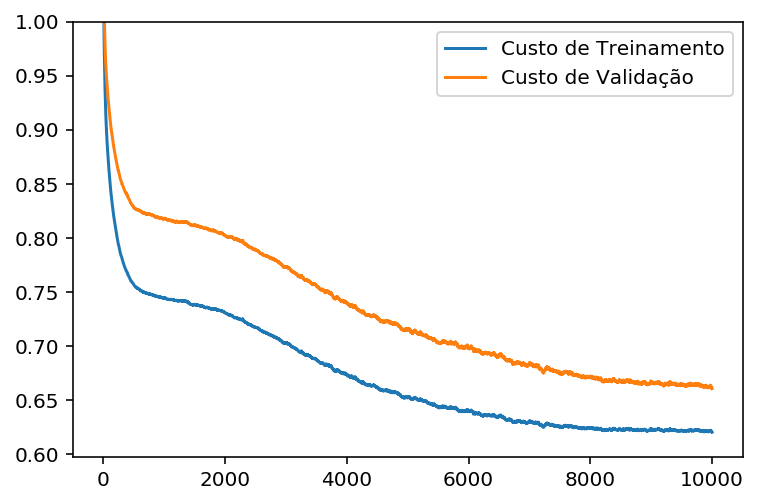

In [391]:
plt.plot(losses['train'], label='Custo de Treinamento')
plt.plot(losses['validation'], label='Custo de Validação')
plt.legend()
plt.ylim(ymax=1.)

## Checando as previsões

Os dados de previsão para a função Z1 serão verificados em relação aos dados de teste. Conforme pode ser visto no gráfico, as previsões ficaram bastante aderentes aos dados.

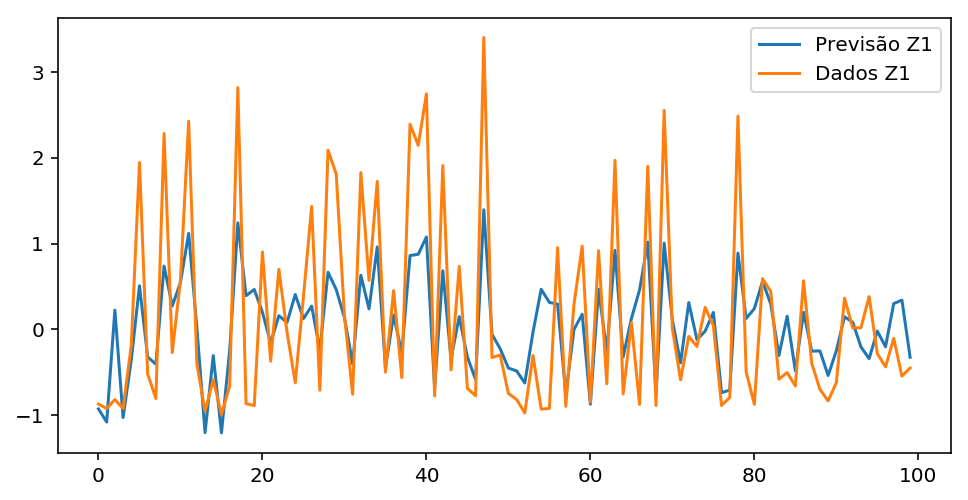

In [392]:
fig4, ax4 = plt.subplots(figsize=(8,4))

mean, std = scaled_features['Z1']
predictions = network.run(test_features)*std + mean
ax4.plot(predictions[0], label='Previsão Z1')
ax4.plot((test_targets['Z1']*std + mean).values, label='Dados Z1')
ax4.legend()

